In [1]:
import numpy as np
import pandas as pd
import os
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
import optuna
from imblearn.over_sampling import SMOTE


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(r"E:\DATA SCIENCE & AI\DATASET\youtube_comment_analysis\final_processed_df.csv")

In [3]:
df.dropna(subset=['clean_comment'],inplace=True)

In [4]:
import dagshub
dagshub.init(repo_owner='Pravat-21', repo_name='ML-Project-YouTube-Comment-Analysis', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow")

Accessing as Pravat-21

Initialized MLflow to track repo "Pravat-21/ML-Project-YouTube-Comment-Analysis"

Repository Pravat-21/ML-Project-YouTube-Comment-Analysis initialized!

In [5]:
df['category'] = df['category'].map({-1:2,0:0,1:1})

In [6]:
df.sample()

,clean_comment,category
32157,but siddhu paaji think otherwise,0


In [7]:
ngram_range = (1,3)
max_features = 800

vectorizer = TfidfVectorizer(ngram_range=ngram_range,max_features=max_features)

X = vectorizer.fit_transform(df['clean_comment'])
y= df["category"]

smote = SMOTE(random_state=21)
X,y = smote.fit_resample(X,y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=21,stratify=y)

### **Model choosing:**

In [8]:
mlflow.set_experiment("Exp 5 : Models-Comparision")

<Experiment: artifact_location='mlflow-artifacts:/b8b09ff6ca1645c9b58c46fddda73397', creation_time=1763794729048, experiment_id='5', last_update_time=1763794729048, lifecycle_stage='active', name='Exp 5 : Models-Comparision', tags={}>

In [9]:
def objective_XG(trial):

    n_estimators = trial.suggest_int("n_estimators",50,400)
    learning_rate = trial.suggest_float("learning_rate", 1e-4,1e-1, log = True)
    max_depth = trial.suggest_int("max_depth",3,15)

    model = XGBClassifier(n_estimators=n_estimators,learning_rate = learning_rate,max_depth=max_depth)

    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
        
    accuracy=accuracy_score(y_test,y_pred)

    return accuracy

def objective_SVC(trial):

    C = trial.suggest_float("C",0.1,100,log=True)
    kernel = trial.suggest_categorical("kernel",['linear','rbf','poly','sigmoid'])
    gamma = trial.suggest_categorical("gamma",['auto','scale'])

    model = SVC(C=C,kernel=kernel,gamma=gamma)

    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
        
    accuracy=accuracy_score(y_test,y_pred)

    return accuracy

def objective_LGBM(trial):

    n_estimators = trial.suggest_int("n_estimators",50,300)
    learning_rate = trial.suggest_float("learning_rate", 1e-4,1e-1, log = True)
    max_depth = trial.suggest_int("max_depth",3,10)

    model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth= max_depth)

    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
        
    accuracy=accuracy_score(y_test,y_pred)

    return accuracy

def objective_NB(trial):

    alpha = trial.suggest_float('alpha',0.01,1)

    model = MultinomialNB(alpha=alpha)


    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
        
    accuracy=accuracy_score(y_test,y_pred)

    return accuracy

def objective_RF(trial):

    n_estimators = trial.suggest_int("n_estimators",50,400)
    max_depth = trial.suggest_int("max_depth",3,15)
    criterion = trial.suggest_categorical("criterion",['gini','entropy','log_loss'])

    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, criterion= criterion)
    model.fit(X_train,y_train)
    
    y_pred=model.predict(X_test)
        
    accuracy=accuracy_score(y_test,y_pred)

    return accuracy


model_dict = {
    "XGboost":objective_XG,
    "LGBM":objective_LGBM,
    "SVC":objective_SVC,
    "NB":objective_NB,
    "RF":objective_RF
}

In [15]:
def run_HT(objective,name:str):
    study = optuna.create_study(direction='maximize',study_name=name)
    study.optimize(objective,n_trials=25)

    best_paramter = study.best_params
    
    return best_paramter

In [16]:
def log_mlflow(objective,name):
    with mlflow.start_run() as run:

        mlflow.set_tags({
            "mlflow.runName":f"Model_HPT for {name}",
            "Experiment_type":"Model Comparision",
            "Description":f"Model name = {name}"
        })

        best_paramters = run_HT(objective,name)

        mlflow.log_param("Model-name",name)
        for key, value in best_paramters.items():
            mlflow.log_param(f"{key}",value)

        if name == "XGboost":
            model = XGBClassifier(**best_paramters)
        elif name == "LGBM":
            model = LGBMClassifier(**best_paramters)
        elif name == "SVC":
            model = SVC(**best_paramters)
        elif name == "NB":
            model = MultinomialNB(**best_paramters)
        elif name == "RF":
            model = RandomForestClassifier(**best_paramters)

        model.fit(X_train,y_train)

        y_pred=model.predict(X_test)
        accuracy=accuracy_score(y_test,y_pred)
        mlflow.log_metric("accuracy",accuracy)

        class_rep = classification_report(y_test,y_pred,output_dict=True)
        
        for label, metrics in class_rep.items():
            if isinstance(metrics, dict):  # for precision, recall, f1-score
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}", value)
                    
        con_matrix = confusion_matrix(y_test,y_pred)

        plt.figure(figsize=(8,6))
        sns.heatmap(con_matrix,annot=True, fmt="d",cmap="Blues")
        plt.title(f"Confusion Matrix for {model} in model_coparision")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")

        plt.savefig("model_confusion.png")
        
        mlflow.log_artifact("model_confusion.png")

        mlflow.sklearn.log_model(model, f"{name}_model")
        print(f"model-{name} done")
        


In [17]:
model_dict

{'XGboost': <function __main__.objective_XG(trial)>,
 'LGBM': <function __main__.objective_LGBM(trial)>,
 'SVC': <function __main__.objective_SVC(trial)>,
 'NB': <function __main__.objective_NB(trial)>,
 'RF': <function __main__.objective_RF(trial)>}

[I 2025-11-22 17:54:16,374] A new study created in memory with name: XGboost
[I 2025-11-22 17:57:22,949] Trial 0 finished with value: 0.6364404988374551 and parameters: {'n_estimators': 179, 'learning_rate': 0.0006234671929155794, 'max_depth': 12}. Best is trial 0 with value: 0.6364404988374551.
[I 2025-11-22 17:59:19,633] Trial 1 finished with value: 0.5656309448319594 and parameters: {'n_estimators': 397, 'learning_rate': 0.00010244663283658533, 'max_depth': 6}. Best is trial 0 with value: 0.6364404988374551.
[I 2025-11-22 17:59:26,195] Trial 2 finished with value: 0.6427816529274994 and parameters: {'n_estimators': 52, 'learning_rate': 0.054347834756971775, 'max_depth': 4}. Best is trial 2 with value: 0.6427816529274994.
[I 2025-11-22 18:02:49,235] Trial 3 finished with value: 0.7572394842528006 and parameters: {'n_estimators': 282, 'learning_rate': 0.02316815916164488, 'max_depth': 11}. Best is trial 3 with value: 0.7572394842528006.
[I 2025-11-22 18:05:07,138] Trial 4 finished wit

model-XGboost done
🏃 View run Model_HPT for XGboost at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5/runs/494bd42bf5f54d758a65d89ca5558aed
🧪 View experiment at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5


[I 2025-11-22 18:58:02,780] A new study created in memory with name: LGBM


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:07,055] Trial 0 finished with value: 0.5373071232297612 and parameters: {'n_estimators': 240, 'learning_rate': 0.0002985739517900489, 'max_depth': 4}. Best is trial 0 with value: 0.5373071232297612.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-ch

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:10,278] Trial 1 finished with value: 0.5364616360177552 and parameters: {'n_estimators': 187, 'learning_rate': 0.0001693300218210047, 'max_depth': 4}. Best is trial 0 with value: 0.5373071232297612.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:11,613] Trial 2 finished with value: 0.5695413231874867 and parameters: {'n_estimators': 98, 'learning_rate': 0.007417577906644171, 'max_depth': 3}. Best is trial 2 with value: 0.5695413231874867.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training f

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:20,807] Trial 3 finished with value: 0.5894102726696259 and parameters: {'n_estimators': 272, 'learning_rate': 0.0008058184547548743, 'max_depth': 7}. Best is trial 3 with value: 0.5894102726696259.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054775 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:25,315] Trial 4 finished with value: 0.6114986260832805 and parameters: {'n_estimators': 112, 'learning_rate': 0.0008409981276674082, 'max_depth': 9}. Best is trial 4 with value: 0.6114986260832805.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:29,806] Trial 5 finished with value: 0.5974424011836821 and parameters: {'n_estimators': 111, 'learning_rate': 0.0005346896423694156, 'max_depth': 8}. Best is trial 4 with value: 0.6114986260832805.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:37,915] Trial 6 finished with value: 0.6135066582117945 and parameters: {'n_estimators': 252, 'learning_rate': 0.0027917935194780087, 'max_depth': 6}. Best is trial 6 with value: 0.6135066582117945.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:41,907] Trial 7 finished with value: 0.7594588881843162 and parameters: {'n_estimators': 108, 'learning_rate': 0.05059468341867823, 'max_depth': 10}. Best is trial 7 with value: 0.7594588881843162.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:47,386] Trial 8 finished with value: 0.5796871697315578 and parameters: {'n_estimators': 152, 'learning_rate': 0.00028672354253450854, 'max_depth': 7}. Best is trial 7 with value: 0.7594588881843162.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.048881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:49,048] Trial 9 finished with value: 0.5660536884379623 and parameters: {'n_estimators': 60, 'learning_rate': 0.003073468390062325, 'max_depth': 5}. Best is trial 7 with value: 0.7594588881843162.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:58:55,042] Trial 10 finished with value: 0.7878883956880152 and parameters: {'n_estimators': 192, 'learning_rate': 0.09918439835432791, 'max_depth': 10}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.055134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:01,265] Trial 11 finished with value: 0.7852462481504967 and parameters: {'n_estimators': 191, 'learning_rate': 0.08370889646174587, 'max_depth': 10}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:08,503] Trial 12 finished with value: 0.786725850771507 and parameters: {'n_estimators': 200, 'learning_rate': 0.0814823646451099, 'max_depth': 10}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:17,049] Trial 13 finished with value: 0.7498414711477489 and parameters: {'n_estimators': 217, 'learning_rate': 0.02311130396244427, 'max_depth': 9}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.070993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:27,706] Trial 14 finished with value: 0.7664341576833651 and parameters: {'n_estimators': 298, 'learning_rate': 0.02396529086159282, 'max_depth': 9}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.053795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:32,819] Trial 15 finished with value: 0.7839780173324878 and parameters: {'n_estimators': 156, 'learning_rate': 0.0945130367775782, 'max_depth': 10}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:40,676] Trial 16 finished with value: 0.6996406679348974 and parameters: {'n_estimators': 218, 'learning_rate': 0.012220522608312483, 'max_depth': 8}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:46,069] Trial 17 finished with value: 0.7293384062566054 and parameters: {'n_estimators': 156, 'learning_rate': 0.02656195096932066, 'max_depth': 8}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.059541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:54,448] Trial 18 finished with value: 0.6794546607482562 and parameters: {'n_estimators': 207, 'learning_rate': 0.0075234315404432974, 'max_depth': 10}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 18:59:58,729] Trial 19 finished with value: 0.735996618051152 and parameters: {'n_estimators': 160, 'learning_rate': 0.040190922106375856, 'max_depth': 6}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 19:00:07,721] Trial 20 finished with value: 0.7078841682519552 and parameters: {'n_estimators': 239, 'learning_rate': 0.011217344433859392, 'max_depth': 9}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 19:00:13,835] Trial 21 finished with value: 0.7826041006129782 and parameters: {'n_estimators': 185, 'learning_rate': 0.06471986751080616, 'max_depth': 10}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 19:00:20,013] Trial 22 finished with value: 0.7857746776580005 and parameters: {'n_estimators': 196, 'learning_rate': 0.08440657001556222, 'max_depth': 10}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 19:00:26,255] Trial 23 finished with value: 0.7871485943775101 and parameters: {'n_estimators': 206, 'learning_rate': 0.09596498115257371, 'max_depth': 9}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
[I 2025-11-22 19:00:31,069] Trial 24 finished with value: 0.7523779327837666 and parameters: {'n_estimators': 136, 'learning_rate': 0.039361679893662224, 'max_depth': 9}. Best is trial 10 with value: 0.7878883956880152.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90609
[LightGBM] [Info] Number of data points in the train set: 37848, number of used features: 783
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

e:\DATA SCIENCE & AI\PROJECTS\Youtube Comment Analysis\youtubevenv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
2025/11/22 19:00:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


model-LGBM done
🏃 View run Model_HPT for LGBM at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5/runs/6ab06b0b515b4053aeca5531e6e0bbd9
🧪 View experiment at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5


[I 2025-11-22 19:01:01,818] A new study created in memory with name: SVC
[I 2025-11-22 19:06:26,650] Trial 0 finished with value: 0.8114563517226802 and parameters: {'C': 59.07309511274913, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8114563517226802.
[I 2025-11-22 19:09:16,143] Trial 1 finished with value: 0.5488268864933418 and parameters: {'C': 3.2828532707040856, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.8114563517226802.
[I 2025-11-22 19:16:10,919] Trial 2 finished with value: 0.7034453603889241 and parameters: {'C': 1.1242565944592113, 'kernel': 'poly', 'gamma': 'scale'}. Best is trial 0 with value: 0.8114563517226802.
[I 2025-11-22 19:18:02,384] Trial 3 finished with value: 0.7333544705136334 and parameters: {'C': 0.13777362564233053, 'kernel': 'linear', 'gamma': 'scale'}. Best is trial 0 with value: 0.8114563517226802.
[I 2025-11-22 19:21:02,553] Trial 4 finished with value: 0.4352145423800465 and parameters: {'C': 0.861156643374

model-SVC done
🏃 View run Model_HPT for SVC at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5/runs/7d61da4cf7cf47d791003ec32d857439
🧪 View experiment at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5


[I 2025-11-22 21:24:07,039] A new study created in memory with name: NB
[I 2025-11-22 21:24:07,085] Trial 0 finished with value: 0.7082012259564574 and parameters: {'alpha': 0.26117139757216296}. Best is trial 0 with value: 0.7082012259564574.
[I 2025-11-22 21:24:07,105] Trial 1 finished with value: 0.7072500528429507 and parameters: {'alpha': 0.3834689985158485}. Best is trial 0 with value: 0.7082012259564574.
[I 2025-11-22 21:24:07,125] Trial 2 finished with value: 0.7075671105474529 and parameters: {'alpha': 0.3608620826942586}. Best is trial 0 with value: 0.7082012259564574.
[I 2025-11-22 21:24:07,140] Trial 3 finished with value: 0.7077784823504545 and parameters: {'alpha': 0.08626990010227267}. Best is trial 0 with value: 0.7082012259564574.
[I 2025-11-22 21:24:07,152] Trial 4 finished with value: 0.7072500528429507 and parameters: {'alpha': 0.38911433450713506}. Best is trial 0 with value: 0.7082012259564574.
[I 2025-11-22 21:24:07,177] Trial 5 finished with value: 0.70788416825

model-NB done
🏃 View run Model_HPT for NB at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5/runs/908bb0ccb0924f6da170c67765140a1e
🧪 View experiment at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5


[I 2025-11-22 21:24:36,480] A new study created in memory with name: RF
[I 2025-11-22 21:24:45,205] Trial 0 finished with value: 0.6792432889452547 and parameters: {'n_estimators': 203, 'max_depth': 14, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.6792432889452547.
[I 2025-11-22 21:24:52,066] Trial 1 finished with value: 0.6669837243711689 and parameters: {'n_estimators': 234, 'max_depth': 11, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.6792432889452547.
[I 2025-11-22 21:25:07,802] Trial 2 finished with value: 0.683999154512788 and parameters: {'n_estimators': 398, 'max_depth': 15, 'criterion': 'gini'}. Best is trial 2 with value: 0.683999154512788.
[I 2025-11-22 21:25:08,958] Trial 3 finished with value: 0.6432043965335025 and parameters: {'n_estimators': 53, 'max_depth': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0.683999154512788.
[I 2025-11-22 21:25:11,350] Trial 4 finished with value: 0.6177340942718241 and parameters: {'n_estimators': 166, 'max_de

model-RF done
🏃 View run Model_HPT for RF at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5/runs/006ac095d1b546d6b6fa73e8ed6fb0ae
🧪 View experiment at: https://dagshub.com/Pravat-21/ML-Project-YouTube-Comment-Analysis.mlflow/#/experiments/5


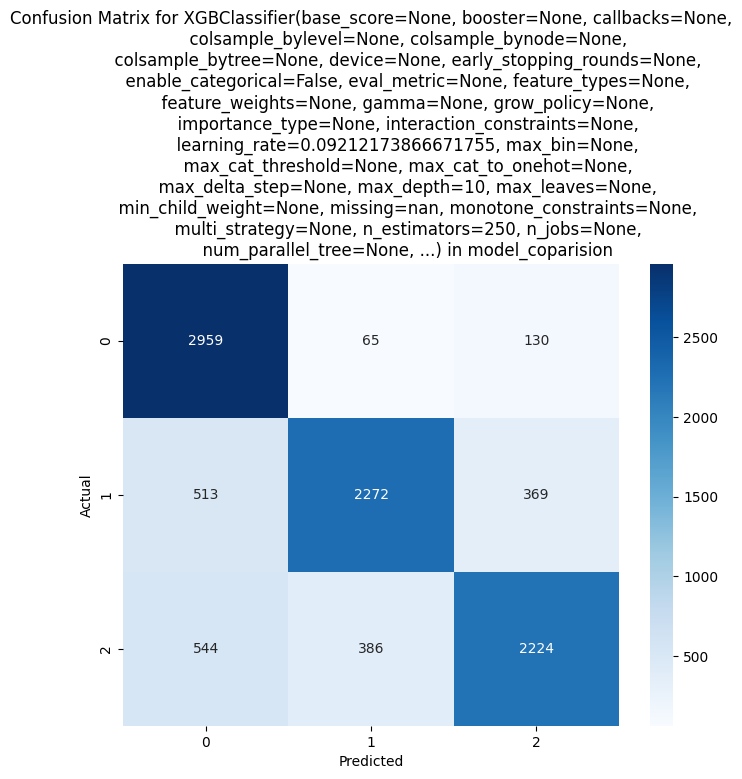

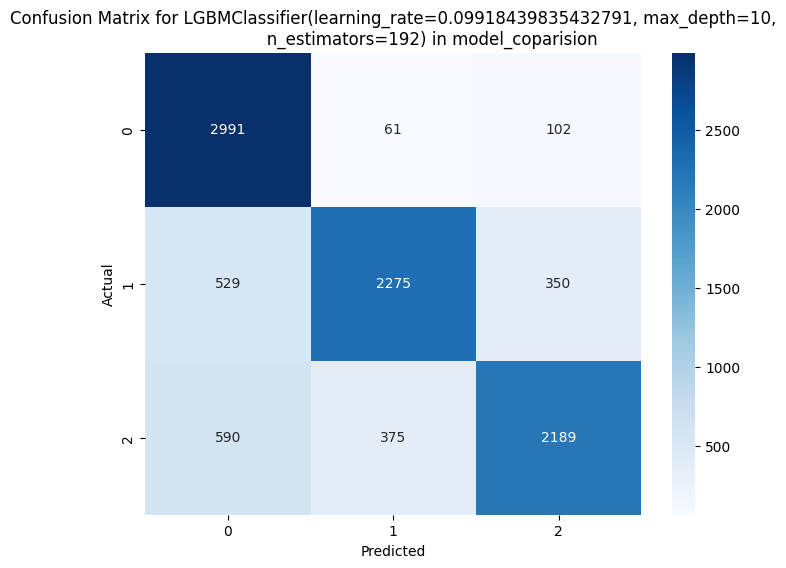

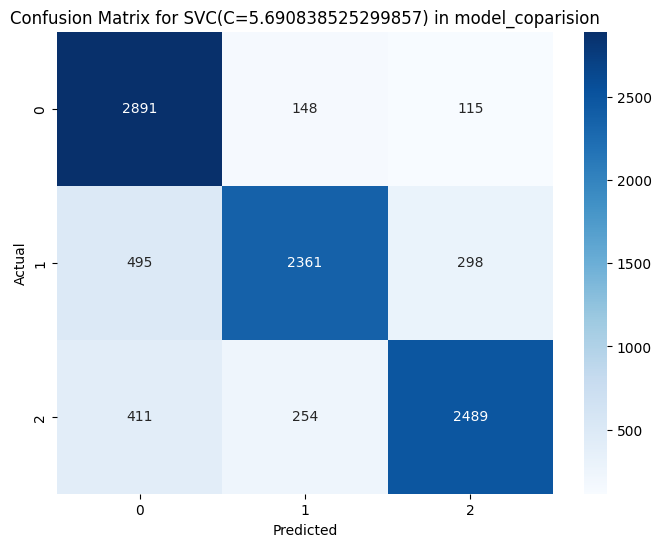

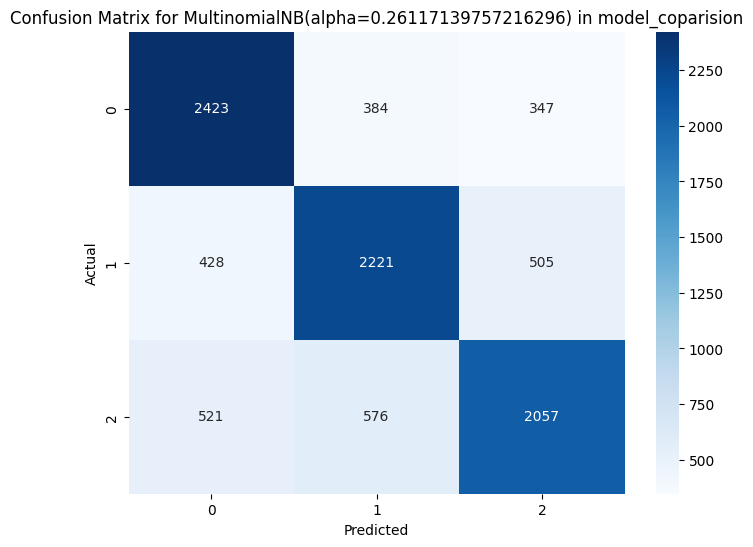

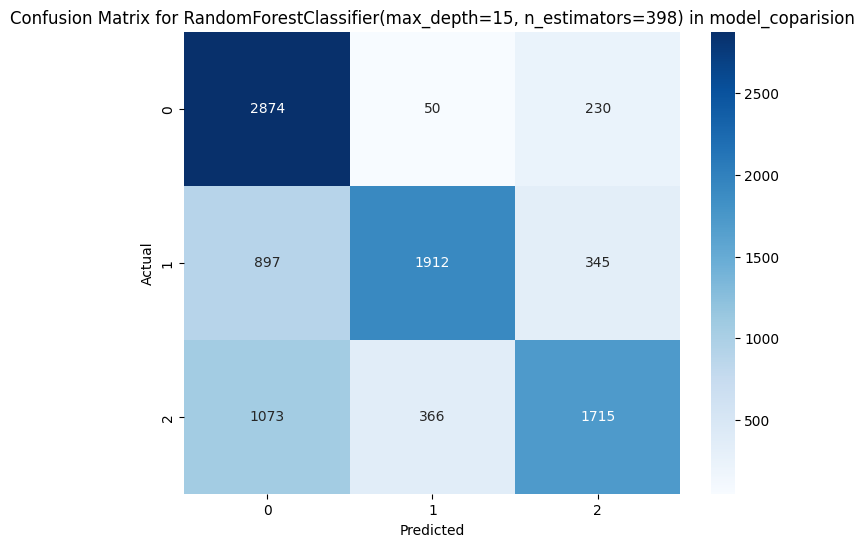

In [18]:
for key,value in model_dict.items():
    log_mlflow(value,key)